## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk
nltk.download('wordnet')
nltk.download("stopwords")
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
!pip install swifter
import swifter #multi-threading/processing
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS
from nltk import pos_tag_sents
nltk.download('averaged_perceptron_tagger')

#df_clean['pos']=pos_tag_sents(df_clean['complaint'].apply(word_tokenize).tolist())

!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
#mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Opening JSON file 
#f = open("/content/gdrive/MyDrive/NLP_Assignment/Ticket_Classification_Case_Study/complaints.json" ,"r")
f = open("/content/gdrive/MyDrive/data/ticket_classification/complaints.json" ,"r")
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.sample(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
8725,complaint-public-v2,complaint,2251121,0.0,None,430XX,2251121,Problems caused by my funds being low,2016-12-15T12:00:00-05:00,OH,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2016-12-15T12:00:00-05:00,None,Checking account,Yes,"Pleaseeee help! \n\nA couple of weeks ago, I r...",None,Consent provided
2369,complaint-public-v2,complaint,626227,0.0,None,442XX,626227,"Loan servicing, payments, escrow account",2013-12-09T12:00:00-05:00,OH,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-12-09T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
35473,complaint-public-v2,complaint,130952,0.0,None,22042,130952,Billing disputes,2012-08-07T12:00:00-05:00,VA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2012-08-08T12:00:00-05:00,None,None,Yes,,None,N/A
1381,complaint-public-v2,complaint,933208,0.0,None,94112,933208,"Loan modification,collection,foreclosure",2014-07-11T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2014-07-16T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
32410,complaint-public-v2,complaint,3861056,0.0,None,21702,3861056,"Other features, terms, or problems",2020-09-23T12:00:00-05:00,MD,...,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2020-09-23T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Problem with balance transfer,Consent not provided


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#Assign new column names
#df['_source.issue'].value_counts()
df.columns=[col.replace("_source.","") for col in df.columns]

In [8]:
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
df.rename(columns={'complaint_what_happened':"complaint", "_index":"index", "_type":"type", "_id":"id", "_score":"score"}, inplace=True)

In [10]:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [12]:
import numpy as np
df['complaint'] = df.complaint.replace('', np.nan)


In [13]:
df.complaint.isna().sum()

57241

In [14]:
#Remove all rows where complaints column is nan
df=df[~df.complaint.isna()]


In [15]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re
def clean_data(column):
  # change complaint to lower case
  column = column.apply(lambda x:x.lower())
  # Remove punctuation
  column  = column.replace(to_replace =r'[^\w\s]', value = ' ', regex = True)
  #remove words from square bracket
  column  = column.replace(to_replace =r'\[.*?\]', value = ' ', regex = True)
  #remove words containing number
  column  = column.replace(to_replace =r'\w*\d\w*', value = ' ', regex = True)

  return column

In [17]:
pd.options.display.max_colwidth = 10000
df_cleaned = clean_data(df['complaint'])
df_cleaned = pd.DataFrame(df_cleaned)
df_cleaned.head(2)

,complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me


In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   complaint  21072 non-null  object
dtypes: object(1)
memory usage: 329.2+ KB


In [19]:
# Remove stop words
stop = stopwords.words('english')
df_cleaned['complaint_without_stopwords'] = df_cleaned['complaint'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
#Write your function to Lemmatize the texts
def lemmatize(sentance):
    sent = []
    doc = nlp(sentance)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)


In [21]:
df_cleaned['lemmatize'] = df_cleaned['complaint_without_stopwords'].swifter.apply(lemmatize)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [22]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df_cleaned[['complaint','lemmatize']]


In [23]:
df_clean.head(2)

,complaint,lemmatize
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable asking bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xx xx tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx without consent xxxx record agent mislead


In [24]:
#Write your function to extract the POS tags 
def get_POS_tags(text):
    sentence = []
    blob = TextBlob(text)
    sentence = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sentence)

In [25]:
df_clean['complaint_POS_removed'] = df_clean['lemmatize'].swifter.apply(get_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   lemmatize              21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




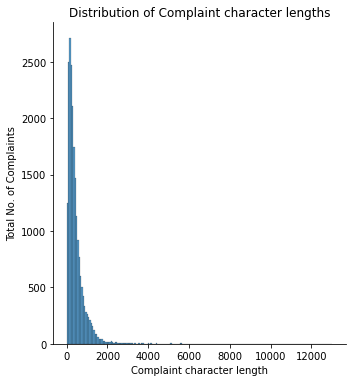

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
length = [len(i) for i in df_clean['complaint_POS_removed']]

sns.displot(length, kind='hist', bins=200)
plt.xlabel("Complaint character length")
plt.ylabel("Total No. of Complaints")
plt.title("Distribution of Complaint character lengths")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

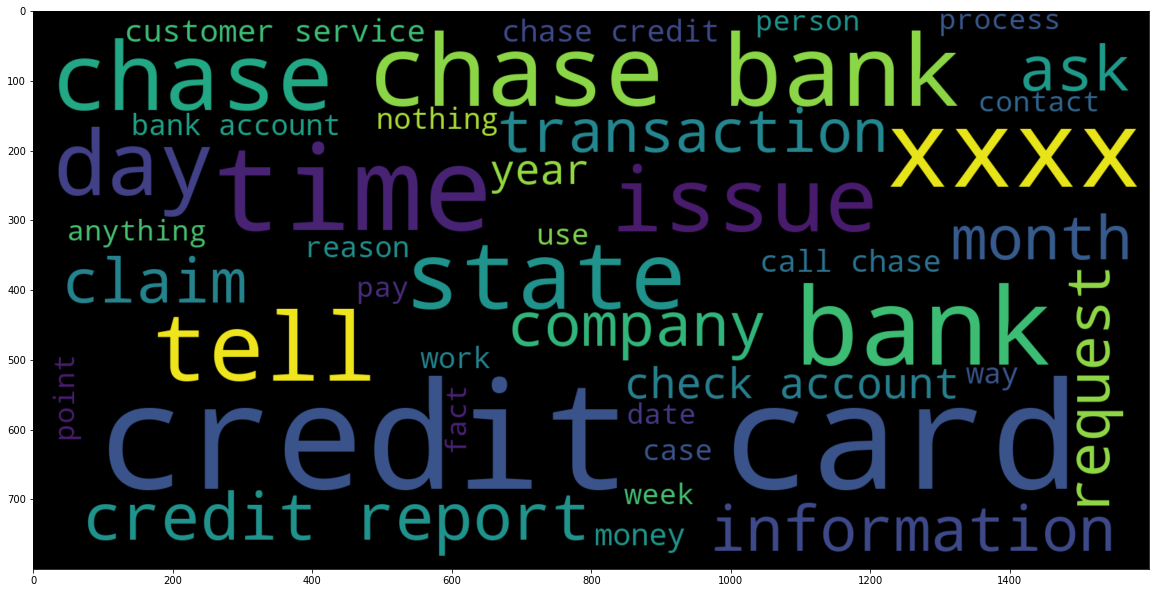

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
plt.figure(figsize = (20,20)) 
stopwords = set(STOPWORDS)
wc = WordCloud(max_words = 40 , width = 1600 , height = 800, stopwords=stopwords, random_state=25 ).generate(" ".join(df_clean.complaint_POS_removed))
plt.imshow(wc, interpolation = 'bilinear')



In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('PRON', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
'''
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
unigram_fd = nltk.FreqDist(nltk.u(df_clean['complaint']))
'''

def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]


top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
#df_unigram.head()
df_unigram.head(30)

,unigram,count
0,chase,54190
1,account,43564
2,credit,34304
3,bank,28455
4,card,26573
5,payment,21337
6,charge,17279
7,time,16041
8,xxxx,13790
9,day,13215


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram.head(30)

,bigram,count
0,credit card,12650
1,chase bank,5233
2,credit report,4012
3,check account,3227
4,customer service,3082
5,chase credit,3034
6,bank account,2537
7,account chase,2318
8,chase account,2085
9,account account,1879


In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram.head(30)

,trigram,count
0,chase credit card,2167
1,credit card company,1005
2,credit card account,911
3,credit card chase,719
4,credit card credit,497
5,charge credit card,495
6,chase customer service,483
7,inquiry credit report,407
8,chase check account,387
9,credit report credit,379


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xx','')

In [35]:
#All masked texts has been removed
df_clean.head(2)

,complaint,lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable asking bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xx xx tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx without consent xxxx record agent mislead,xxxx card agent date information order upgrade account change anniversary date consent xxxx record agent mislead,card agent date information order upgrade account change anniversary date consent record agent mislead


In [36]:
#df_clean.to_csv('clean_data.csv')


In [37]:
#df_clean=pd.read_csv("/content/clean_data.csv")

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
vector=TfidfVectorizer(stop_words="english", min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
df_clean=df_clean[~df_clean.complaint_POS_removed.isna()]
text=df_clean['Complaint_clean']
tfidf = vector.fit_transform(df_clean['Complaint_clean'])

# Save the feature names for later to create topic summaries
tfidf_fn = vector.get_feature_names()

In [40]:
vector.get_feature_names()

['aa',
 'aarp',
 'ab',
 'aback',
 'abandon',
 'abandonment',
 'abatement',
 'abbreviation',
 'abet',
 'abhorrent',
 'abide',
 'ability',
 'abovementione',
 'abrupt',
 'abscond',
 'absence',
 'absent',
 'absolute',
 'absolve',
 'absorb',
 'abstract',
 'absurd',
 'absurdity',
 'abundance',
 'abuse',
 'abusive',
 'ac',
 'acc',
 'acccount',
 'accelerate',
 'acceleration',
 'accent',
 'accept',
 'acceptance',
 'access',
 'accessibility',
 'accessory',
 'accident',
 'acco',
 'accommodate',
 'accommodation',
 'accomodate',
 'accomodation',
 'accompany',
 'accomplice',
 'accomplish',
 'accord',
 'accordance',
 'accou',
 'accouint',
 'accoun',
 'accound',
 'account',
 'accountability',
 'accountand',
 'accountant',
 'accountholder',
 'accounting',
 'accredit',
 'accrue',
 'acct',
 'accumulate',
 'accumulation',
 'accunt',
 'accuracy',
 'accurate',
 'accusation',
 'accusatory',
 'accuse',
 'ach',
 'achieve',
 'acion',
 'ack',
 'acknowledge',
 'acknowledgement',
 'acknowledgment',
 'acocunt',
 'a

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF
#Load your nmf_model with the n_components i.e 5
from sklearn.decomposition import NMF
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf = NMF(
    n_components=num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=40
) #write your code here

nmf.fit(tfidf)
len(vector.get_feature_names())



6945

In [42]:
tfidf.shape

(21072, 6945)

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
H = nmf.components_       # Topic-term matrix

In [44]:
#Print the top 5 words for each of the topics
words = np.array(vector.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 5)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(5)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:5]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5
Topic 1,account,bank,check,money,chase
Topic 2,credit,card,report,inquiry,chase
Topic 3,loan,mortgage,chase,home,modification
Topic 4,charge,fee,card,dispute,chase
Topic 5,payment,pay,balance,month,statement


In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
results = nmf.transform(tfidf)


In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = results.argmax(axis=1)  #write your code to assign topics to each rows.

In [47]:
df_clean.head()

,complaint,lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable asking bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xx xx tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx without consent xxxx record agent mislead,xxxx card agent date information order upgrade account change anniversary date consent xxxx record agent mislead,card agent date information order upgrade account change anniversary date consent record agent mislead,1
10,chase card was reported on xx xx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,1
11,on xx xx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on xx xx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,

In [48]:
df_clean.shape

(21072, 5)

In [49]:
#Print the first 5 Complaint for each of the Topics
df_clean_temp=df_clean.groupby('Topic').head(2)
df_clean_temp.sort_values('Topic')

,complaint,lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable asking bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx xx check number xxxx claim number is xxxx with chase,grand son give check deposit chase account fund clear chase bank closed account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase times tell call verify check owner country time date happen xx xx check number xxxx claim number xxxx chase,son check deposit chase account fund chase bank account money son check money bank refuse pay money son call chase verify check owner country time date number claim number chase,son check deposit chase account fund chase bank account money son check money bank refuse pay money son call chase verify check owner country time date number claim number chase,0
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xx xx tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx without consent xxxx record agent mislead,xxxx card agent date information order upgrade account change anniversary date consent xxxx record agent mislead,card agent date information order upgrade account change anniversary date consent record agent mislead,1
10,chase card was reported on xx xx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,1
57,i have been trying to do a loan modification with chase and all they do is give me the runaround i m mo behind they dont let me make payments i have aens all doc in but always asking more,try loan modification chase give runaround mo behind do not let make payment aen doc always ask,try loan modification chase runaround 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [50]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Others",
               3:"Theft/Dispute Reporting", 4:"Mortgage/Loan" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [51]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [52]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0, "Credit card or prepaid card":1, "Others":2,
               "Theft/Dispute Reporting":3, "Mortgage/Loan":4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [53]:
df_clean

,complaint,lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable asking bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,morning name appreciate chase bank cardmember service chase debt verification statement bank debt mail month attempt debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in xx xx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card xx xx tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx without consent xxxx record agent mislead,xxxx card agent date information order upgrade account change anniversary date consent xxxx record agent mislead,card agent date information order upgrade account change anniversary date consent record agent mislead,1
10,chase card was reported on xx xx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,1
11,on xx xx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on xx xx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,

In [54]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint','Topic']]

In [55]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [56]:
X=tfidf
y=training_data.Topic.values

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [58]:
X_train.shape

(16857, 6945)

In [59]:
X_test.shape

(4215, 6945)

In [60]:
y_train.shape

(16857,)

In [61]:
y_test.shape

(4215,)

In [62]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   lemmatize              21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 987.8+ KB


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [64]:
# Getting the score of the base model
logistic_reg.score(X_test, y_test)

0.9544483985765124

Decision Tree

In [65]:
# Import DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [66]:
# Train, Test Split
#X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

decision_tree.score(X_test, y_test) # Score the model

0.8493475682087782

Random Forest 

In [67]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier


In [68]:
# Train, Test Split
#X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) # Instantiate model

random_forest.score(X_test, y_test) # Score the model

0.8733096085409253

Naive Bayes

In [69]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred)
print(F'ACC : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC : 0.767497034400949
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1074
           1       0.73      0.82      0.77       996
           2       0.82      0.83      0.82       757
           3       0.79      0.78      0.78       920
           4       0.94      0.22      0.36       468

    accuracy                           0.77      4215
   macro avg       0.80      0.71      0.71      4215
weighted avg       0.78      0.77      0.75      4215



##Final Comments on Model evaluation

As shown above, Logistic egression is giving us around 95%

#Conclusion

we will go ahead with logistic regression